Q：动作的奖励/Q表中的值   V：状态的奖励   Π：策略  R:奖励  γ：衰减 α：学习率
S：状态  A：动作

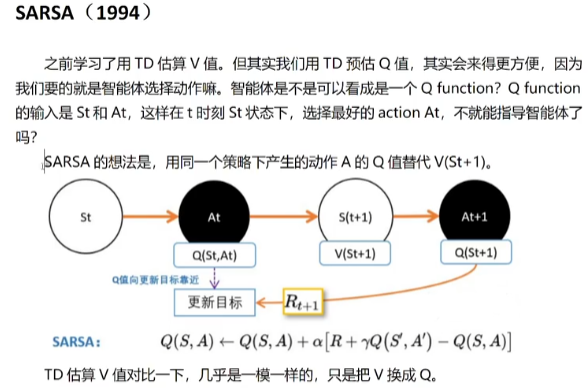
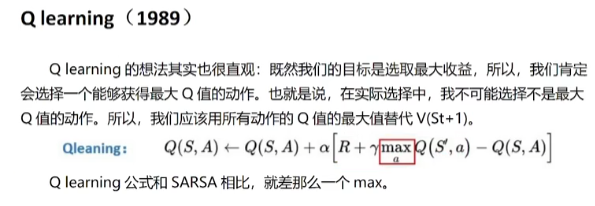
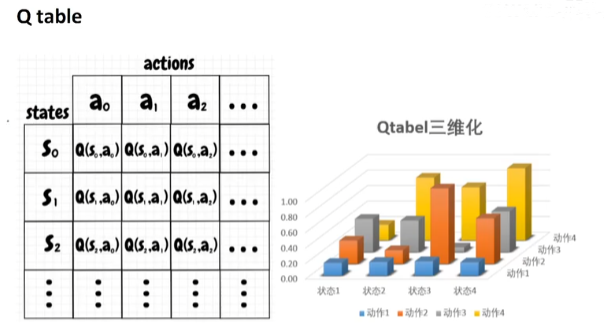

两个都是调整表中值的方法  不要理解为选取动作的策论  这里的策论全是选取最大的
二者不同点在于是target 值的计算不同

QLearning是选取下一个状态下中最大的值  下一状态是跟据当前动作来的  当前动作是跟据当前状态的最大值的动作
Sarsa则是选取下一个状态下指定的下一动作的值  下一状态是跟据当前动作来的  当前动作是跟据当前状态的最大值的动作
下一动作是跟据下一状态的最大值的动作

最终唯一的变量是当前状态  而当前状态是和跟据前一动作来的  依次循环往复



In [1]:
#绘制环境
import numpy as np
import time
import sys
if sys.version_info.major == 2:
    import Tkinter as tk
else:
    import tkinter as tk


In [3]:
UNIT = 40   # 以40个像素为一个单位
MAZE_H = 4  # 图形的高度格子数量  
MAZE_W = 4  # 图形的宽度格子数量  

In [4]:
"""
举例1    常用参数 https://blog.csdn.net/qdPython/article/details/130623162
import tkinter as tk
class MyApp(object):
  def __init__(self, parent):
    self.rootframe = tk.Frame(parent)
    self.rootframe.pack()
    self.setupUI()
  def setupUI(self):
    tk.Label(self.rootframe, text='标签').pack()
if __name__ == '__main__':
  root = tk.Tk()
  MyApp(root) # 注意这句
  root.mainloop()
"""
"""
举例2
  def __init__(self, screenName=None, baseName=None, className='Tk',
                 useTk=1, sync=0, use=None):
Return a new Toplevel widget on screen SCREENNAME. A new Tcl interpreter will
        be created. BASENAME will be used for the identification of the profile file (see
        readprofile).
        It is constructed from sys.argv[0] without extensions if None is given. CLASSNAME
        is the name of the widget class.
"""

class Maze(tk.Tk, object): #继承两个父类 主继承是tk这时一种简写 另一种在上面举例1里给出
    def __init__(self):
        super(Maze, self).__init__()#初始化tk类  super默认是第一个  tk类上面举例2给出
        self.action_space = ['u', 'd', 'l', 'r']  #动作空间
        self.n_actions = len(self.action_space)  #有多少个动作
        self.title('maze')  #修改框体的名字,也可在创建时使用className参数
        self.geometry('{0}x{1}'.format(MAZE_W * UNIT, MAZE_H * UNIT))  #root.geometry('250x150')　　指定主框体大小；  {0}x{1}就是指的调用的顺序
        self._build_maze()

    def _build_maze(self):
        self.canvas = tk.Canvas(self, bg='white',#  Canvas        　　绘图形组件，可以在其中绘制图形；
                           height=MAZE_H * UNIT,
                           width=MAZE_W * UNIT)

        # create grids
        for c in range(0, MAZE_W * UNIT, UNIT):  #从0-MAZE_W * UNIT以UNIT为间隔
            x0, y0, x1, y1 = c, 0, c, MAZE_H * UNIT
            self.canvas.create_line(x0, y0, x1, y1)  #划线
        for r in range(0, MAZE_H * UNIT, UNIT):
            x0, y0, x1, y1 = 0, r, MAZE_W * UNIT, r
            self.canvas.create_line(x0, y0, x1, y1)

        # create origin
        origin = np.array([20, 20])

        # hell
        hell1_center = origin + np.array([UNIT * 2, UNIT])   
        self.hell1 = self.canvas.create_rectangle(   #绘制矩形((a,b,c,d),值为左上角和右下角的坐标)
            hell1_center[0] - 15, hell1_center[1] - 15,
            hell1_center[0] + 15, hell1_center[1] + 15,
            fill='black')
        # hell
        hell2_center = origin + np.array([UNIT, UNIT * 2])
        self.hell2 = self.canvas.create_rectangle(
            hell2_center[0] - 15, hell2_center[1] - 15,
            hell2_center[0] + 15, hell2_center[1] + 15,
            fill='black')

        # create oval
        oval_center = origin + UNIT * 2
        self.oval = self.canvas.create_oval(   #绘制椭圆
            oval_center[0] - 15, oval_center[1] - 15,
            oval_center[0] + 15, oval_center[1] + 15,
            fill='yellow')

        # create red rect
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='red')

        # pack all
        self.canvas.pack()  #pack函数布局的时候，默认先使用的放到上面，然后依次向下排列，
        #默认方式它会给我们的组件一个自认为合适的位置和大小。

    def reset(self):
        self.update()  #刷新页面  类里面的不是自己写的s
        time.sleep(0.5)
        self.canvas.delete(self.rect)  #删除绘制的图形
        origin = np.array([20, 20])
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='red')
        # return observation
        return self.canvas.coords(self.rect)  #返回对象的位置的两个坐标（4个数字元组）

    def step(self, action):  #调用时需传入动作  rect时机器人  oval是目标 hell是陷阱
        s = self.canvas.coords(self.rect)  #返回当前机器人的位置  左极值点、上极值点、右极值点、下极值点   画布的坐标原点在左上角
        base_action = np.array([0, 0])  #代表横纵坐标
        if action == 0:   # up  向上  
            if s[1] > UNIT:  #上极值点大于40  意思是上面是有空间的可以移动  否则就不可以移动 
                base_action[1] -= UNIT# 向上和左都是减号   0是横 1是纵

        elif action == 1:   # down
            if s[1] < (MAZE_H - 1) * UNIT:
                base_action[1] += UNIT
        elif action == 2:   # right
            if s[0] < (MAZE_W - 1) * UNIT:
                base_action[0] += UNIT
        elif action == 3:   # left
            if s[0] > UNIT:
                base_action[0] -= UNIT

        self.canvas.move(self.rect, base_action[0], base_action[1])  # move agent

        s_ = self.canvas.coords(self.rect)  # next state  #这时移动后的坐标 保存下来 在下一个状态还要用
        #print(s_)
        # reward function   将设置奖励的功能也写入
        if s_ == self.canvas.coords(self.oval):  #如果当前的机器人坐标是目标坐标  奖励是1 done结束  当前的机器人坐标就设置成terminal
            reward = 1
            done = True
            s_ = 'terminal'  #前的机器人坐标就设置成terminal不代表完成任务  而是代表机器人不可以动了 此轮要结束了 需要重新开局
        elif s_ in [self.canvas.coords(self.hell1), self.canvas.coords(self.hell2)]:
            reward = -1
            done = True
            s_ = 'terminal'
        else:
            reward = 0
            done = False  #  普通时候  那么机器人的状态还是机器人的坐标  

        return s_, reward, done

    def render(self):  #这是一个绘制函数
        time.sleep(0.1)
        self.update()




In [ ]:
env = Maze()
# def after(self, ms, func, *args)
#env.after(100, env.render)
s, r, done = env.step(1)
time.sleep(0.5)#这两步就是更新  代码中将这两步合在一起叫做render
env.update()
s, r, done = env.step(1)
env.render()
env.mainloop()

In [5]:

import numpy as np
import pandas as pd

class RL(object):  #建立父类  方便后续  二者就是更新不同罢了 
    def __init__(self, action_space, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = action_space  # a list  动作的列表
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy

        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64) #建立一个空表  pd.DataFrame建立二维表  指定了行
    
    def display_q_table(self):  #展示表
        display(self.q_table)
        
    def check_state_exist(self, state):  #检查输入状态是否存在
        if state not in self.q_table.index:  #如果不存在  新建一行
            # append new state to q table
            self.q_table = self.q_table.append(
                pd.Series(   #建立一维数组
                    [0]*len(self.actions),  #改行有多少个列 列的值是多少
                    index=self.q_table.columns,#该行的列的名称是什么
                    name=state,#该行的名字
                )
            )

    def choose_action(self, observation): #跟据输入的状态选择动作
        self.check_state_exist(observation)#先确定一下当前的状态是否存在
        # action selection
        if np.random.rand() < self.epsilon:   #给一个随机 目的是能够探索  探索的概率是0.1
            # choose best action
            state_action = self.q_table.loc[observation, :]  #定位当前状态也就是当前行的  所有动作下的值
            # some actions may have the same value, randomly choose on in these actions
            # np.max(state_action)找到这些动作中最大的值  
            #state_action == np.max(state_action)  这些值挨个和最大值看是否相等  这时折些值就变成了TRUE和FALSE 
            #state_action[state_action == np.max(state_action)]  把是TRUE的拿出来
            #state_action[state_action == np.max(state_action)].index  #指出这些TRUE的列名字
            # np.random.choice(state_action[state_action == np.max(state_action)].index)  是防止多个相同的 就是拿出来好几个 那就随机选
            action = np.random.choice(state_action[state_action == np.max(state_action)].index)  #
        else:
            # choose random action
            action = np.random.choice(self.actions)#这就是0.1机会的探索
        return action

    def learn(self, *args):  #两个方法的方式不一样
        pass


# off-policy
class QLearningTable(RL):
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
         #super是父类  调用QLearningTable的父类的初始化 而不是调用QLearningTable的初始化 要不然那不死循环了  super的参数就是class 和 self 
        #旧式类表示深度遍历调用的类 然后重复选前面  新式类是选择后面
        #如果继承两个类 则是按照先后顺序继承
        super(QLearningTable, self).__init__(actions, learning_rate, reward_decay, e_greedy)   
 
        
    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        q_predict = self.q_table.loc[s, a]
        if s_ != 'terminal':
            q_target = r + self.gamma * self.q_table.loc[s_, :].max()  # next state is not terminal
        else:
            q_target = r  # next state is terminal
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)  # update


# on-policy
class SarsaTable(RL):

    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        super(SarsaTable, self).__init__(actions, learning_rate, reward_decay, e_greedy)

        
    def learn(self, s, a, r, s_, a_):
        self.check_state_exist(s_)
        q_predict = self.q_table.loc[s, a]
        if s_ != 'terminal':
            q_target = r + self.gamma * self.q_table.loc[s_, a_]  # next state is not terminal
        else:
            q_target = r  # next state is terminal
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)  # update

class SarsaLambdaTable(RL):
   
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9, trace_decay=0.9):
        super(SarsaLambdaTable, self).__init__(actions, learning_rate, reward_decay, e_greedy)

        # backward view, eligibility trace.
        self.lambda_ = trace_decay
        self.eligibility_trace = self.q_table.copy()
    
    def display_eligibility_trace(self):  #展示表
        display(self.eligibility_trace)
        
    def check_state_exist(self, state):
        if state not in self.q_table.index:
            # append new state to q table
            to_be_append = pd.Series(
                    [0] * len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            self.q_table = self.q_table.append(to_be_append)

            # also update eligibility trace
            self.eligibility_trace = self.eligibility_trace.append(to_be_append)

    def learn(self, s, a, r, s_, a_):
        self.check_state_exist(s_)
        q_predict = self.q_table.loc[s, a]
        if s_ != 'terminal':
            q_target = r + self.gamma * self.q_table.loc[s_, a_]  # next state is not terminal
        else:
            q_target = r  # next state is terminal
        error = q_target - q_predict

        # increase trace amount for visited state-action pair

        # Method 1:
        # self.eligibility_trace.loc[s, a] += 1

        # Method 2:
        self.eligibility_trace.loc[s, :] *= 0
        self.eligibility_trace.loc[s, a] = 1

        # Q update
        self.q_table += self.lr * error * self.eligibility_trace

        # decay eligibility trace after update
        self.eligibility_trace *= self.gamma*self.lambda_



In [6]:
#主函数

def QLearningUpdate():
    for episode in range(100): # env.after(100, update)  在100毫秒内如果时间够就跑100个回合   如果100毫秒还跑不完就下一轮  防止一直跑
        # initial observation
        observation = env.reset()   #observation代表机器人当前的坐标

        while True:
            # fresh env
            env.render()  #每次渲染一下

            # RL choose action based on observation
            action = RL.choose_action(str(observation))  #跟据策略在表中选择合适的动作

            # RL take action and get next observation and reward
            observation_, reward, done = env.step(action)  #跟据动作  进行画面渲染和计算奖励和判断该回合是否结束

            # RL learn from this transition
            RL.learn(str(observation), action, reward, str(observation_))#跟据这几个参数更新表 实际上就是跟据公式改数

            # swap observation
            observation = observation_

            # break while loop when end of this episode
            if done:
                break

    # end of game
    print('game over')
    env.destroy()


def SarsaUpdate():
    for episode in range(100):
        # initial observation
        observation = env.reset()

        # RL choose action based on observation
        action = RL.choose_action(str(observation))

        while True:
            # fresh env
            env.render()

            # RL take action and get next observation and reward
            observation_, reward, done = env.step(action)

            # RL choose action based on next observation
            action_ = RL.choose_action(str(observation_))

            # RL learn from this transition (s, a, r, s, a) ==> Sarsa
            Sarsa.learn(str(observation), action, reward, str(observation_), action_)

            # swap observation and action
            observation = observation_
            action = action_

            # break while loop when end of this episode
            if done:
                break

    # end of game
    print('game over')
    env.destroy()


def SarsaLambdaUpdate():
    for episode in range(100):
        # initial observation
        observation = env.reset()

        # RL choose action based on observation
        action = RL.choose_action(str(observation))

        # initial all zero eligibility trace
        RL.eligibility_trace *= 0

        while True:
            # fresh env
            env.render()

            # RL take action and get next observation and reward
            observation_, reward, done = env.step(action)

            # RL choose action based on next observation
            action_ = RL.choose_action(str(observation_))

            # RL learn from this transition (s, a, r, s, a) ==> Sarsa
            RL.learn(str(observation), action, reward, str(observation_), action_)

            # swap observation and action
            observation = observation_
            action = action_

            # break while loop when end of this episode
            if done:
                break

    # end of game
    print('game over')
    env.destroy()



In [123]:
env = Maze() 
RL = QLearningTable(actions=list(range(env.n_actions)))  #传入动作的列表   n_actions在地图中实现 是动作空间的长度 range(start, stop [,step]) 顺序生成 0-n_actions
env.after(100, QLearningUpdate)
env.mainloop()

C:\Users\XL\AppData\Local\Temp\ipykernel_9648\2699483878.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(
C:\Users\XL\AppData\Local\Temp\ipykernel_9648\2699483878.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(
C:\Users\XL\AppData\Local\Temp\ipykernel_9648\2699483878.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(
C:\Users\XL\AppData\Local\Temp\ipykernel_9648\2699483878.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(
C:\Users\XL\AppData\Local\Temp\ipykernel_9648\2699483878.py:

In [125]:
RL.display_q_table()

,0,1,2,3
"[5.0, 5.0, 35.0, 35.0]",0.0,0.0,0.00,0.0
"[45.0, 5.0, 75.0, 35.0]",0.0,0.0,0.00,0.0
"[85.0, 5.0, 115.0, 35.0]",0.0,0.0,0.00,0.0
"[5.0, 45.0, 35.0, 75.0]",0.0,0.0,0.00,0.0
"[5.0, 85.0, 35.0, 115.0]",0.0,0.0,-0.01,0.0
terminal,0.0,0.0,0.00,0.0


In [115]:
env = Maze()
RL = SarsaTable(actions=list(range(env.n_actions)))
env.after(100, SarsaUpdate)
env.mainloop()

C:\Users\XL\AppData\Local\Temp\ipykernel_9648\853004620.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(
C:\Users\XL\AppData\Local\Temp\ipykernel_9648\853004620.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(
C:\Users\XL\AppData\Local\Temp\ipykernel_9648\853004620.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(
C:\Users\XL\AppData\Local\Temp\ipykernel_9648\853004620.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(
C:\Users\XL\AppData\Local\Temp\ipykernel_9648\853004620.py:18: F

In [116]:
RL.display_q_table()

,0,1,2,3
"[5.0, 5.0, 35.0, 35.0]",0.00,0.0,0.0,0.0
"[5.0, 45.0, 35.0, 75.0]",0.00,0.0,0.0,0.0
"[45.0, 5.0, 75.0, 35.0]",0.00,0.0,0.0,0.0
"[45.0, 45.0, 75.0, 75.0]",0.00,0.0,0.0,0.0
"[5.0, 85.0, 35.0, 115.0]",0.00,0.0,0.0,0.0
"[5.0, 125.0, 35.0, 155.0]",0.00,0.0,0.0,0.0
"[45.0, 125.0, 75.0, 155.0]",-0.01,0.0,0.0,0.0
terminal,0.00,0.0,0.0,0.0


In [11]:
env = Maze()
RL = SarsaLambdaTable(actions=list(range(env.n_actions)))
env.after(100, SarsaLambdaUpdate)
env.mainloop()

C:\Users\XL\AppData\Local\Temp\ipykernel_11776\3378464926.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(to_be_append)
C:\Users\XL\AppData\Local\Temp\ipykernel_11776\3378464926.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.eligibility_trace = self.eligibility_trace.append(to_be_append)
C:\Users\XL\AppData\Local\Temp\ipykernel_11776\3378464926.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(to_be_append)
C:\Users\XL\AppData\Local\Temp\ipykernel_11776\3378464926.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.eligibility_trace = self

In [12]:
RL.display_q_table(),RL.display_eligibility_trace()

,0,1,2,3
"[5.0, 5.0, 35.0, 35.0]",-2.717488e-03,-0.009832,-0.008763,-0.002890
"[45.0, 5.0, 75.0, 35.0]",-2.628923e-03,-0.021881,-0.015583,-0.002141
"[5.0, 45.0, 35.0, 75.0]",-1.697637e-03,-0.015018,-0.006917,-0.001781
"[5.0, 85.0, 35.0, 115.0]",-1.014269e-04,-0.002824,-0.029701,-0.000267
terminal,0.000000e+00,0.000000,0.000000,0.000000
"[85.0, 5.0, 115.0, 35.0]",-9.361595e-05,-0.019900,-0.003945,-0.000081
"[125.0, 5.0, 155.0, 35.0]",-7.217100e-05,-0.005115,-0.000072,-0.000004
"[125.0, 45.0, 155.0, 75.0]",-6.561000e-08,0.003487,0.000000,-0.010000
"[45.0, 45.0, 75.0, 75.0]",-1.696628e-04,-0.029701,-0.010000,-0.000162
"[5.0, 125.0, 35.0, 155.0]",-3.918991e-06,0.000000,-0.008100,0.000000


,0,1,2,3
"[5.0, 5.0, 35.0, 35.0]",8.100000e-01,0.0,0.0,0.000000e+00
"[45.0, 5.0, 75.0, 35.0]",0.000000e+00,0.0,0.0,1.690018e-07
"[5.0, 45.0, 35.0, 75.0]",1.824800e-02,0.0,0.0,0.000000e+00
"[5.0, 85.0, 35.0, 115.0]",2.018689e-119,0.0,0.0,0.000000e+00
terminal,0.000000e+00,0.0,0.0,0.000000e+00
"[85.0, 5.0, 115.0, 35.0]",0.000000e+00,0.0,0.0,4.123198e-45
"[125.0, 5.0, 155.0, 35.0]",0.000000e+00,0.0,0.0,0.000000e+00
"[125.0, 45.0, 155.0, 75.0]",0.000000e+00,0.0,0.0,0.000000e+00
"[45.0, 45.0, 75.0, 75.0]",1.700076e-89,0.0,0.0,0.000000e+00
"[5.0, 125.0, 35.0, 155.0]",0.000000e+00,0.0,0.0,0.000000e+00


(None, None)

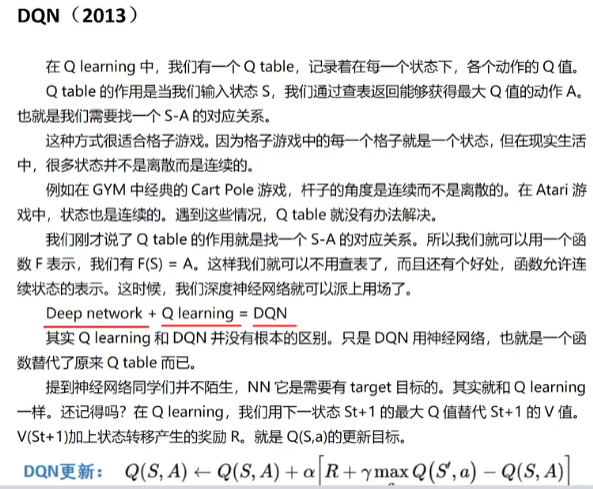
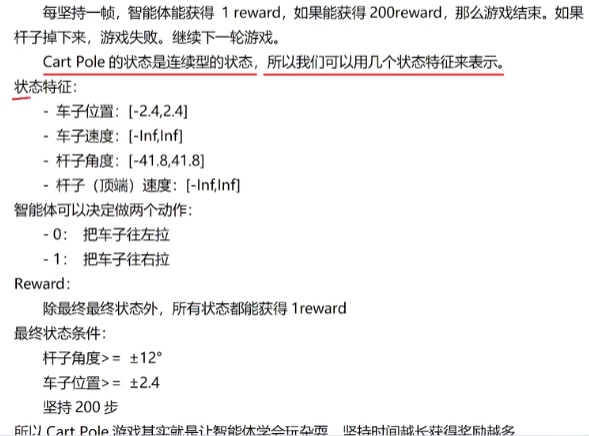

其实DQN就是深度学习加Qlearning，我们知道在Qlearning中有三个重点 一个是状态和动作的表
使得我们可以跟据状态选择合适的动作，还有一个就是如何更新表的值，这里有上面讲的三个方法
第三个重点就是选择动作的策略
我们接下来就是讲第一个重点，本来我们建立一个表来构建状态和动作的关系，这时有个局限就是只能是离散值
如果我们用一个函数来构建二者的关系，那就可以是一个连续值了，而如何构建这个函数，这时就可以用神经网络了
这样我们就可以跟据函数输入状态输出合适的动作，这样就可以跟据Qlearning更新出下一时刻的目标样本存在replaybuffer
够了一个batch继续训练网络

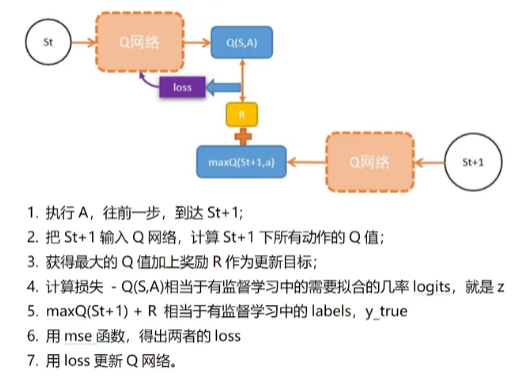
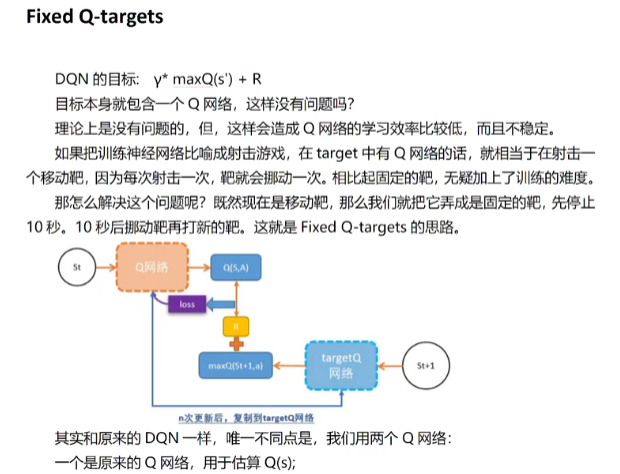
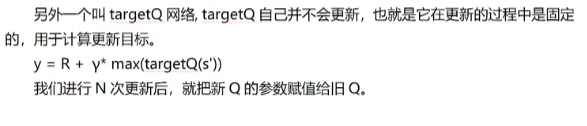
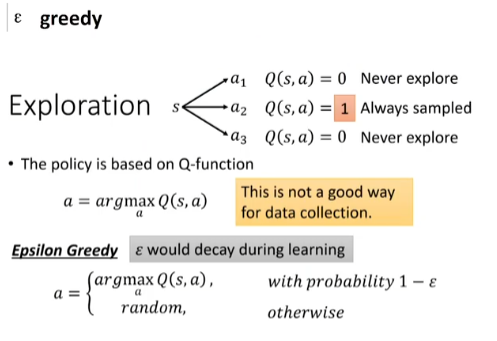
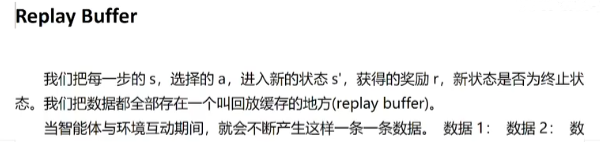
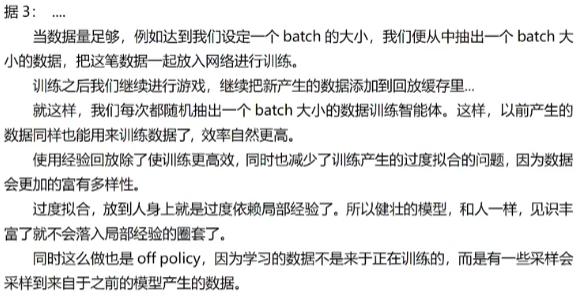

In [4]:
#相较于之前的少了一个hell

import numpy as np
import time
import sys
if sys.version_info.major == 2:
    import Tkinter as tk
else:
    import tkinter as tk

UNIT = 40   # pixels
MAZE_H = 4  # grid height
MAZE_W = 4  # grid width


class Maze(tk.Tk, object):
    def __init__(self):
        super(Maze, self).__init__()
        self.action_space = ['u', 'd', 'l', 'r']
        self.n_actions = len(self.action_space)
        self.n_features = 2
        self.title('maze')
        self.geometry('{0}x{1}'.format(MAZE_W * UNIT, MAZE_H * UNIT))
        self._build_maze()

    def _build_maze(self):
        self.canvas = tk.Canvas(self, bg='white',
                           height=MAZE_H * UNIT,
                           width=MAZE_W * UNIT)

        # create grids
        for c in range(0, MAZE_W * UNIT, UNIT):
            x0, y0, x1, y1 = c, 0, c, MAZE_H * UNIT
            self.canvas.create_line(x0, y0, x1, y1)
        for r in range(0, MAZE_H * UNIT, UNIT):
            x0, y0, x1, y1 = 0, r, MAZE_W * UNIT, r
            self.canvas.create_line(x0, y0, x1, y1)

        # create origin
        origin = np.array([20, 20])

        # hell
        hell1_center = origin + np.array([UNIT * 2, UNIT])
        self.hell1 = self.canvas.create_rectangle(
            hell1_center[0] - 15, hell1_center[1] - 15,
            hell1_center[0] + 15, hell1_center[1] + 15,
            fill='black')
        # hell
        # hell2_center = origin + np.array([UNIT, UNIT * 2])
        # self.hell2 = self.canvas.create_rectangle(
        #     hell2_center[0] - 15, hell2_center[1] - 15,
        #     hell2_center[0] + 15, hell2_center[1] + 15,
        #     fill='black')

        # create oval
        oval_center = origin + UNIT * 2
        self.oval = self.canvas.create_oval(
            oval_center[0] - 15, oval_center[1] - 15,
            oval_center[0] + 15, oval_center[1] + 15,
            fill='yellow')

        # create red rect
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='red')

        # pack all
        self.canvas.pack()

    def reset(self):
        self.update()
        time.sleep(0.1)
        self.canvas.delete(self.rect)
        origin = np.array([20, 20])
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='red')
        # return observation
        return (np.array(self.canvas.coords(self.rect)[:2]) - np.array(self.canvas.coords(self.oval)[:2]))/(MAZE_H*UNIT)

    def step(self, action):
        s = self.canvas.coords(self.rect)
        base_action = np.array([0, 0])
        if action == 0:   # up
            if s[1] > UNIT:
                base_action[1] -= UNIT
        elif action == 1:   # down
            if s[1] < (MAZE_H - 1) * UNIT:
                base_action[1] += UNIT
        elif action == 2:   # right
            if s[0] < (MAZE_W - 1) * UNIT:
                base_action[0] += UNIT
        elif action == 3:   # left
            if s[0] > UNIT:
                base_action[0] -= UNIT

        self.canvas.move(self.rect, base_action[0], base_action[1])  # move agent

        next_coords = self.canvas.coords(self.rect)  # next state

        # reward function
        if next_coords == self.canvas.coords(self.oval):
            reward = 1
            done = True
        elif next_coords in [self.canvas.coords(self.hell1)]:
            reward = -1
            done = True
        else:
            reward = 0
            done = False
        s_ = (np.array(next_coords[:2]) - np.array(self.canvas.coords(self.oval)[:2]))/(MAZE_H*UNIT)
        return s_, reward, done

    def render(self):
        time.sleep(0.01)
        self.update()




In [5]:

import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

np.random.seed(1)
tf.set_random_seed(1)


# Deep Q Network off-policy
class DeepQNetwork:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=300,
            memory_size=500,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        #n_features是2 这代表着输出是两个特征  至于为什么buffer要2*2+2
        #首先这个横坐标指定是memory_size没什么 纵坐标篇我们要记录[s, a, r, s_]
        #其中[s, s_]这两个代表的是机器人的状态实际上就是坐标，也就是特征数也就是2
        #代表着x与y  那么我们将这四个变量堆叠到一起后就变成了[s(x),s(y),a, r,s_(x),s_(y)]
        self.memory = np.zeros((self.memory_size, n_features * 2 + 2))

        # consist of [target_net, evaluate_net]
        self._build_net()
        #tf.get_collection用于根据集合名称获取相关的全部变量引用列表
        t_params = tf.get_collection('target_net_params')
        e_params = tf.get_collection('eval_net_params')
        
        #将eval网络的参数复制到target网络的参数中去，这也是需要sess.run的，可不是一直执行的
        #初始化的时候执行一下，保证两个参数一致
        # tf.assign 函数可以对 tensor 进行整体的赋值
        #zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表。
        # a = [1,2,3] b = [4,5,6] zipped = zip(a,b)     # 打包为元组的列表
        #输出[(1, 4), (2, 5), (3, 6)]
        #range(0, 30, 5)  # 步长为 5
        #输出[0, 5, 10, 15, 20, 25]
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            # tf.train.SummaryWriter soon be deprecated, use following
            tf.summary.FileWriter("logs/", self.sess.graph)
        #全局变量初始化
        self.sess.run(tf.global_variables_initializer())
        self.cost_his = []

    def _build_net(self):
        # ------------------ build evaluate_net ------------------
        #placeholder()函数是在神经网络构建graph的时候在模型中的占位，此时并没有把要输入的数据传入模型，它只会分配必要的内存。
        #等建立session，在会话中，运行模型的时候通过feed_dict()函数向占位符喂入数据。
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss
        #tf.variable_scope('eval_net')指定作用域  这样两个网络的参数不会重复
        with tf.variable_scope('eval_net'):
            # c_names(collections_names) are the collections to store variables
            c_names, n_l1, w_initializer, b_initializer = \
                ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 10, \
                tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)  # config of layers

            # first layer. collections is used later when assign to target net
           
            #tf.get_variable()作用：用于获取已存在的变量(要求不仅名字，而且初始化方法等各个参数都一样)
            #如果不存在，就新建一个。可以用各种初始化方法，不用明确指定值。

            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_eval = tf.matmul(l1, w2) + b2

        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        with tf.variable_scope('train'):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

        # ------------------ build target_net ------------------
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')    # input
        with tf.variable_scope('target_net'):
            # c_names(collections_names) are the collections to store variables
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s_, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_next = tf.matmul(l1, w2) + b2

    def store_transition(self, s, a, r, s_):
        #hasattr() 函数用于判断对象是否包含对应的属性。
        #memory_counter记录有多少条数据
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        #np.hstack将参数元组的元素数组按水平方向进行叠加,
      
        transition = np.hstack((s, [a, r], s_))

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition

        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]
        #为了探索
        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            #q_eval就是正向传播的，这是一个列表 对应的是每一个动作对应的q值
            #输入是机器人当前的状态
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # check to replace target parameters
        #将eval网络的参数复制到target网络的参数中去，这也是需要sess.run的，可不是一直执行的
        #初始化的时候执行一下，保证两个参数一致，每隔一段时间在复制
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)
            print('\ntarget网络被更新\n')

        # 随机在memory中抽取batch_size个数据
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]
        #batch_memory[:, -self.n_features:]  是[:,-2:] 所有行 倒数第二列到最后就是s_ 
        #batch_memory[:, :self.n_features]同理
        q_next, q_eval = self.sess.run(
            [self.q_next, self.q_eval],
            feed_dict={
                self.s_: batch_memory[:, -self.n_features:],  # fixed params
                self.s: batch_memory[:, :self.n_features],  # newest params
            })

        # 防止后续修改q_target就是各个状态对应的动作的值
        q_target = q_eval.copy()
        #返回一个有终点和起点的固定步长的排列（可理解为一个等差数组）。 0~batch_size 
        #生成batch_size的序号 因为每一个batch都存起来 要是一个batch有20条数据 
        #动作空间是2 那么网络的输出20*2  这不是也是深度学习时，矩阵的作用 一次训练好多样本
        #输入是样本数*特征数  输出是分类数*样本数  中间网络就是特征数*分类数
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        #获取r和act
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = batch_memory[:, self.n_features + 1]

        q_target[batch_index, eval_act_index] = reward + self.gamma * np.max(q_next, axis=1)

        #训练
        # train eval network
        #训练需要真实值和预测值   预测值可以通过不变q_target网络前向传播 然后经过公式变成预测值
        #真实值可以通过时变q_eval网络正向传播 之后获得真实值 二者都有了就可以梯度下降了
        #训练是为了减小误差 改变参数  误差是真实值与预测值的差 二者都要有样本 是输入是replaybuffer存的实际也就是 s和s_
        #都是一样的输入一样的网络，为啥会有误差呢 因为两个网络并不是每一此都复制的  需要过几次才会将网络参数复制
        #
        _, self.cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.q_target: q_target})
        self.cost_his.append(self.cost)

        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

    def plot_cost(self):
        import matplotlib.pyplot as plt
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.show()

    def display_memory(self):
        print(self.memory)


In [6]:

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

def run_maze():
    step = 0
    for episode in range(300):
        # 初始化机器人位置  使之回到初始位置1，1
        observation = env.reset()

        while True:
            # 刷新
            env.render()

            #选择动作
            action = RL.choose_action(observation)

            # RL take action and get next observation and reward
            observation_, reward, done = env.step(action)
            #更新replay buffer
            RL.store_transition(observation, action, reward, observation_)
            #首先要保证有200个数据，才可以开始学习  之后就是没5步骤学习一次
            if (step > 200) and (step % 5 == 0):
                RL.learn()

            # swap observation
            observation = observation_

            # break while loop when end of this episode
            if done:
                break
            step += 1

    # end of game
    print('game over')
    env.destroy()



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced



Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Program Files\Spyder\pkgs\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Program Files\Spyder\pkgs\tkinter\__init__.py", line 814, in callit
    func(*args)
  File "C:\Users\XL\AppData\Local\Temp\ipykernel_5296\3237496397.py", line 18, in run_maze
    observation_, reward, done = env.step(action)
  File "C:\Users\XL\AppData\Local\Temp\ipykernel_5296\647718126.py", line 84, in step
    s = self.canvas.coords(self.rect)
  File "C:\Program Files\Spyder\pkgs\tkinter\__init__.py", line 2766, in coords
    self.tk.call((self._w, 'coords') + args))]
_tkinter.TclError: invalid command name ".!canvas"


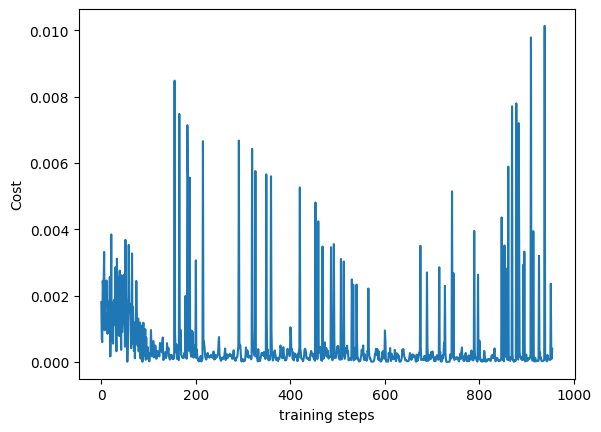

In [7]:
tf.reset_default_graph()#清空所有计算图防止 下次运行时，变量重复
# maze game
env = Maze()

"""
env.n_actions   动作空间  就是有几个动作 上下左右
env.n_features  网络的输入特征数 比如是图片 那就是图片的像素数 那这里应该是坐标  那就是2 因为是横纵坐标
                 实际上我们获取到的是四个角的坐标 所以那就是4 但是这里把它变成中心点的坐标 所以就是2
learning_rate=0.01 学习率     
reward_decay=0.9  衰减率
e_greedy=0.9        探索率
replace_target_iter=200, 200次后将q网络参数复制到  target网络
memory_size=2000,   存储数据的大小，主要作用在当我们要训练数据时候，需要样本  我们使用批量梯度下降
                    所以要存一下数据作为样本 这也有关到网络的形状
output_graph=True 是否输出计算图
"""
RL = DeepQNetwork(env.n_actions, env.n_features,
                  learning_rate=0.01,
                  reward_decay=0.9,
                  e_greedy=0.9,
                  replace_target_iter=200,
                  memory_size=2000,
                  # output_graph=True
                  )
env.after(100, run_maze)
env.mainloop()
RL.plot_cost()

In [2]:
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
   
env.close()
